## Assignment 1 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
##### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

In [ ]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [2]:
#importing the data labels (main dataset)
labels_main = pd.read_csv('Image_classification_data\data_labels_mainData.csv')
print("labels_main DataFrame:")
labels_main.head()

labels_main DataFrame:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
#importing the data labels (extra dataset)
labels_extra = pd.read_csv('Image_classification_data\data_labels_extraData.csv')
print("\nlabels_extra DataFrame:")
labels_extra.head()


labels_extra DataFrame:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [4]:
#defining function to load images
image_folder = 'Image_classification_data\patch_images'
def load_images(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images
#loading the images
image_objects = load_images(image_folder, labels_main['ImageName'])
#adding a new column 'Image' to labels_main
labels_main['Image'] = labels_main['ImageName'].map(image_objects)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image
0,22405,1,22405.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,22406,1,22406.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,22407,1,22407.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,22408,1,22408.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,22409,1,22409.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


## I. Exploratory Data Analysis (EDA)

In [5]:
#dimensions of data frame
labels_main.shape

(9896, 7)

In [6]:
#data types of columns
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
 6   Image         9896 non-null   object
dtypes: int64(4), object(3)
memory usage: 541.3+ KB


In [8]:
#getting the number of unique values in each column
#keeping only columns where all values are hashable (leaving out Image)
hashable_cols = [col for col in labels_main.columns if labels_main[col].map(lambda x: isinstance(x, (int, float, str, bool, type(None)))).all()]
#calculatting unique counts
unique_counts = labels_main[hashable_cols].nunique().sort_values(ascending=False)
print("Number of Unique Values per Column:")
print(unique_counts)


Number of Unique Values per Column:
InstanceID      9896
ImageName       9896
patientID         60
cellTypeName       4
cellType           4
isCancerous        2
dtype: int64


In [12]:
#displaying unique values and value counts for categorical variables found in last code chunk
categorical_cols = ['patientID', 'cellTypeName', 'cellType', 'isCancerous']
for col in categorical_cols:
    print(f"\nColumn: {col}")
    unique_vals = labels_main[col].nunique()
    print(f"Number of unique values: {unique_vals}")
    #showing only top 10 most common values for readability
    print("Top 10 value counts:")
    print(labels_main[col].value_counts().head(10).to_string())
    if unique_vals > 10:
        print("... (truncated for readability)")


Column: patientID
Number of unique values: 60
Top 10 value counts:
patientID
54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
... (truncated for readability)

Column: cellTypeName
Number of unique values: 4
Top 10 value counts:
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386

Column: cellType
Number of unique values: 4
Top 10 value counts:
cellType
2    4079
1    2543
0    1888
3    1386

Column: isCancerous
Number of unique values: 2
Top 10 value counts:
isCancerous
0    5817
1    4079


In [13]:
#evaluation of numerical features within data set
labels_main.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [14]:
#finding total number of images
images = os.listdir(image_folder)
print(f"Total Number of Images: {len(images)}")
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Number of Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))
print("Number of Images in patch_images folder but missing from labels_main:", len(images_set - csv_images_set))
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Total Number of Images: 20280
Number of Images in labels_main but missing from patch_images folder: 0
Number of Images in patch_images folder but missing from labels_main: 10384


In [15]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


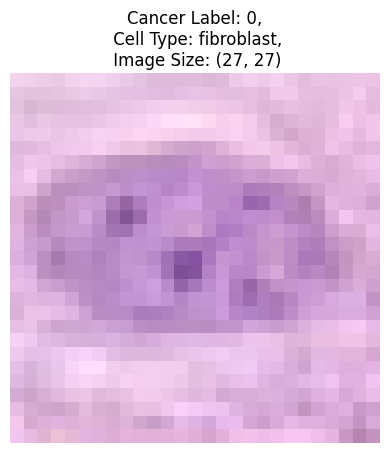

In [16]:
#fetching a single sample (e.g., for index 0)
index = 0
sample = labels_main.iloc[index]
#extracting the image, cancer label, and cell type
img = sample['Image']  # This must be a PIL Image object
cancer_label = sample['isCancerous']
cell_type = sample['cellTypeName']
#displaying the image
if img:
    plt.imshow(img)
    plt.title(f"Cancer Label: {cancer_label},\n Cell Type: {cell_type},\n Image Size: {img.size}")
    plt.axis('off')  #hiding axes
    plt.show()
else:
    print("Error: Image not found.")

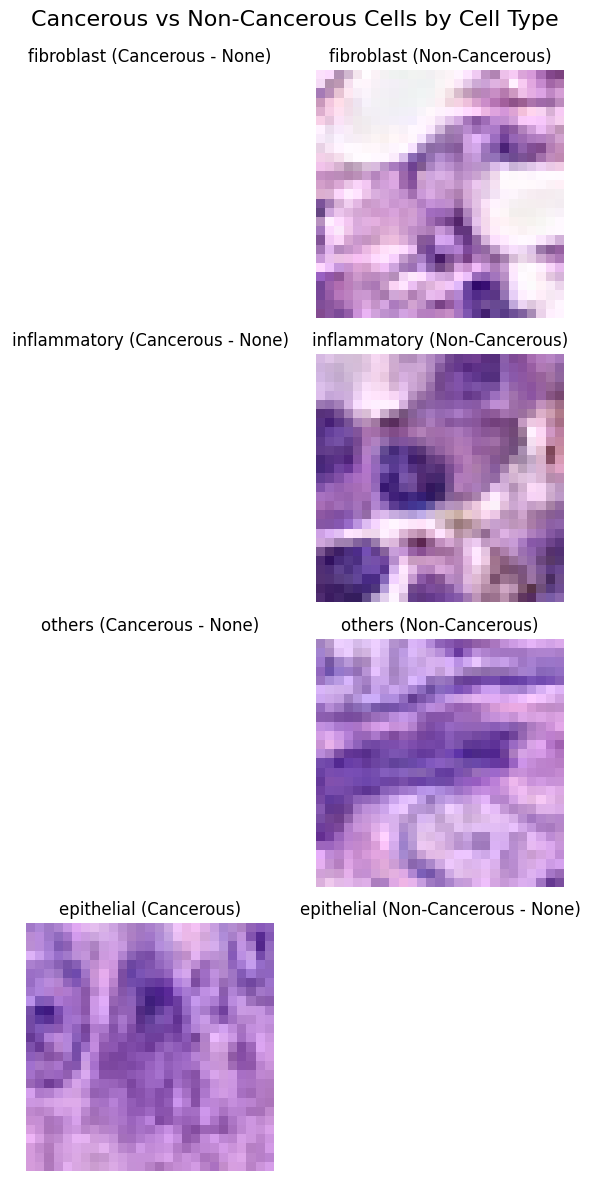

In [17]:
#getting unique cell types
cell_types = labels_main['cellTypeName'].dropna().unique()
#preparing the figure
fig, axes = plt.subplots(len(cell_types), 2, figsize=(6, 3 * len(cell_types)))
#ensure axes is 2D
if len(cell_types) == 1:
    axes = np.expand_dims(axes, axis=0)
#filtering cancerous and non-cancerous data 
for i, cell_type in enumerate(cell_types):
    cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                               (labels_main['isCancerous'] == 1)]
    non_cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                                   (labels_main['isCancerous'] == 0)]
    #plotting cancerous image for cell type
    if not cancerous_df.empty:
        img = cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{cell_type} (Cancerous)")
    else:
        axes[i, 0].set_title(f"{cell_type} (Cancerous - None)")
    axes[i, 0].axis('off')
    #plotting non-cancerous image for cell type
    if not non_cancerous_df.empty:
        img = non_cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous)")
    else:
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous - None)")
    axes[i, 1].axis('off')
#plotting comparison images
plt.suptitle('Cancerous vs Non-Cancerous Cells by Cell Type', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

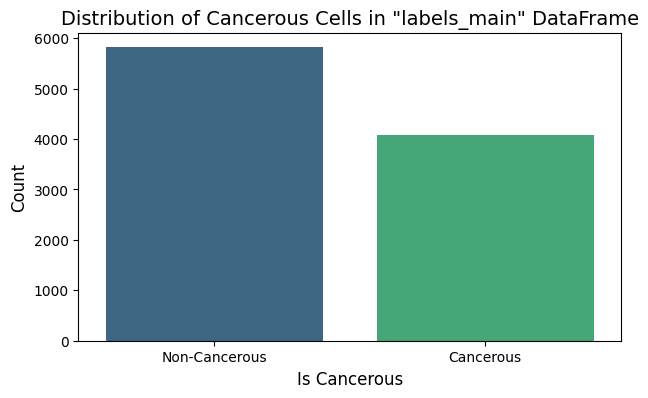

In [18]:
# Plotting the distribution of the 'isCancerous' label
plt.figure(figsize=(7, 4))
sns.countplot(data=labels_main, x='isCancerous', hue="isCancerous", palette='viridis', legend=False)
# Adding titles and labels
plt.title('Distribution of Cancerous Cells in "labels_main" DataFrame', fontsize=14)
plt.xlabel('Is Cancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  # Adjust according to your label values
# Show the plot
plt.show()

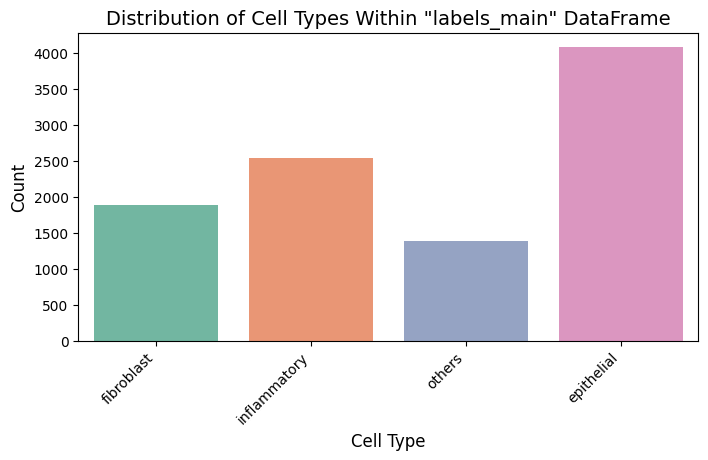

In [19]:
#plotting the distribution of the 'cellTypeName' label
plt.figure(figsize=(8, 4))
sns.countplot(data=labels_main, x='cellTypeName', hue='cellTypeName', palette='Set2', legend=False)
#adding titles and labels
plt.title('Distribution of Cell Types Within "labels_main" DataFrame', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [20]:
#checking for missing values in the entire DataFrame
missing_values = labels_main.isnull().sum()
#displaying the columns with missing values
print("Missing values in each column:")
print(missing_values)
#optionally, you can filter columns with missing values only
missing_columns = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(missing_columns)

Missing values in each column:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
Image           0
dtype: int64

Columns with missing values:
Series([], dtype: int64)


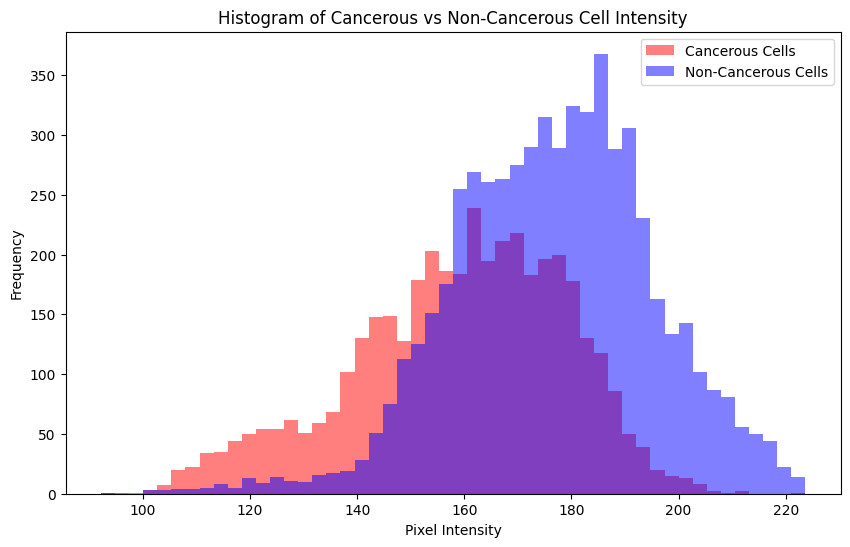

In [ ]:
#defining function to calculate pixel intensity from an 'Image' object
def calculate_pixel_intensity(image_obj):
    #converting image to grayscale
    img_gray = image_obj.convert('L')  #'L' mode is for grayscale images
    #getting the pixel values as a numpy array
    pixel_values = np.array(img_gray)
    #calculating the average pixel intensity
    avg_intensity = pixel_values.mean()
    return avg_intensity

#filtering cancerous and non-cancerous cells from the DataFrame
cancerous_cells = labels_main[labels_main['isCancerous'] == 1].copy()
noncancerous_cells = labels_main[labels_main['isCancerous'] == 0].copy()
#applying the pixel intensity calculation function to each image in the 'Image' column
cancerous_cells.loc[:, 'pixel_intensity'] = cancerous_cells['Image'].apply(calculate_pixel_intensity)
noncancerous_cells.loc[:, 'pixel_intensity'] = noncancerous_cells['Image'].apply(calculate_pixel_intensity)

#extracting the pixel intensities as numpy arrays
cancerous_intensity = cancerous_cells['pixel_intensity'].values
noncancerous_intensity = noncancerous_cells['pixel_intensity'].values
#ensuring they are numpy arrays of floats for histogram calculation
cancerous_intensity = np.array(cancerous_intensity, dtype=float)
noncancerous_intensity = np.array(noncancerous_intensity, dtype=float)

#computing histograms
counts_cancer, bins = np.histogram(cancerous_intensity, bins=50)
counts_non_cancer, _ = np.histogram(noncancerous_intensity, bins=bins)

#plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(cancerous_intensity, bins=bins, alpha=0.5, color='red', label='Cancerous Cells')
plt.hist(noncancerous_intensity, bins=bins, alpha=0.5, color='blue', label='Non-Cancerous Cells')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Cancerous vs Non-Cancerous Cell Intensity')
plt.show()

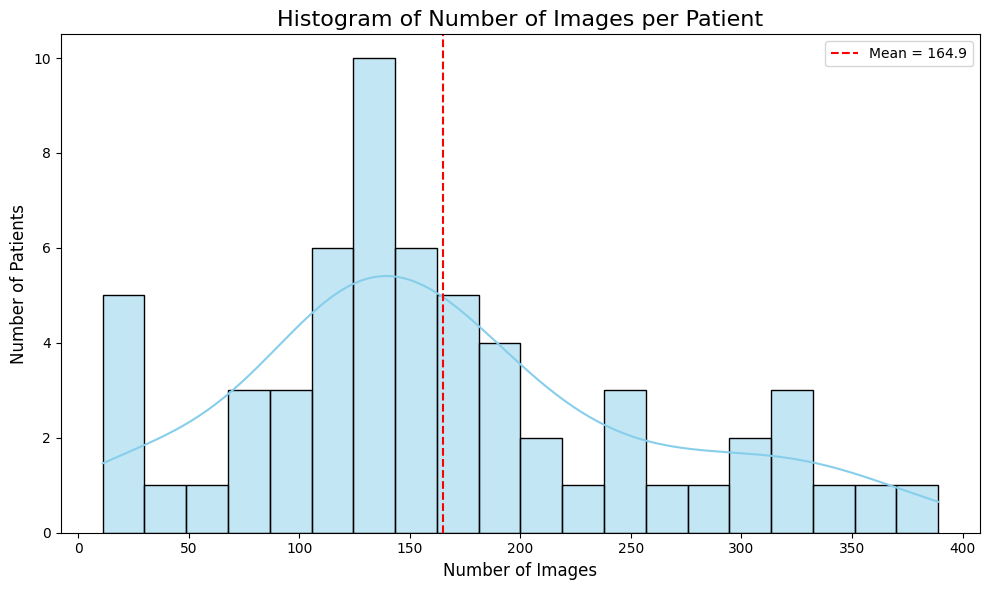

In [37]:
#counting the number of images per 'patientID'
patient_distribution = labels_main['patientID'].value_counts()
#plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(patient_distribution, bins=20, kde=True, color='skyblue')
#plotting mean line
mean_val = patient_distribution.mean()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
plt.title('Histogram of Number of Images per Patient', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12) #number of patients that fall within each range
plt.legend()
plt.tight_layout()
plt.show()

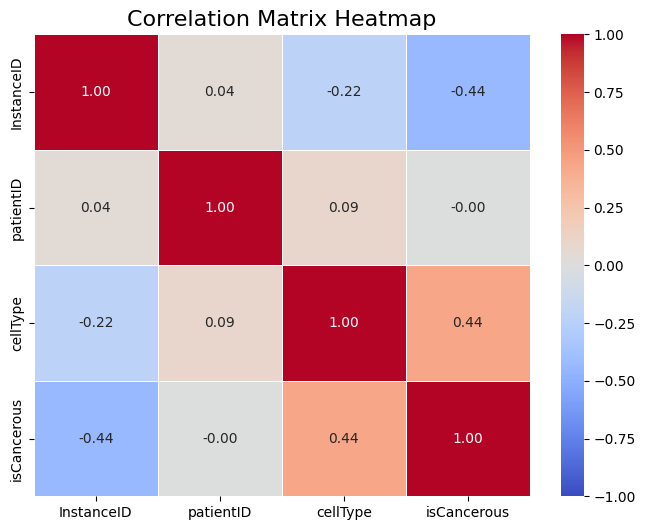

In [35]:
#selecting only numerical features from DataFrame
numerical_features = labels_main.select_dtypes(include=['float64', 'int64'])
#computing and plotting correlation matrix
corr_matrix = numerical_features.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

### *EDA Observations of `labels_main` DataFrame*

- **Dimensions of Dataset**: `labels_main` contains 9,896 rows and 7 columns, a moderately-sized dataset on colon cell histopathologies that may require memory management when training a model.

- **Revealing Data Types**: 

    - Each `InstanceID` appears once so there are 9,896 unique instances of cell histopathologies. --> `int64` data type indicates all values are integers, representing unique instance ID given to each histopathology.
    - `patientID` has 60 unique values, with patient 54 appearing 389 times, indicating that multiple colon cell histopathologies were taken from the same patient, and some more than others. --> `int64` indicates all values are integers, representing unique ID given to each patient. 
    - `ImageName` have string values like `22405.pg` occurring once within `labels_main`. --> `object` data type indicates string values, representing unique image file names.

    - **Target Variables**
    - `cellTypeName` has 4 unique string values indicating a categorical variable = `epithelial`, `inflammatory`, `fibroblast`, `others`; `epithelial` appears twice as much as the next most frequently occuring category, showing that there is a significant class imbalance within this column. --> `object` data type as categories appear as strings (name of colon cell type).
    - `isCancerous` has two unique binary values, 0 (non-cancerous, 5817 instances) and 1 (cancerous, 4079 instances), with more values for non-cancerous colon cells, indicating a class imbalance. --> `int64` data type indicates that presence of cancer is represented by binary classification labels 0 and 1.

- **Evaluating Numerical Features**
    - `InstanceID` is wide-ranging from 1 to 22444, indicating missing IDs, this indicated that this data is not sequential, just a unique identifier for each colon cell histopathology (most likely not useful for modelling).
    - There are multiple samples given per `patientID`, some more than others, indicated by the mean = 29.8 and standard deviation = 17.5, indicating a moderately evenly distribution. Patient-level stratification may be required in model training to avoid data leakage.
    - Observing a slight class imbalance within the `isCancerous` binary variable has mean = 0.41, indicating that there are are higher number of non-cancerous instances than cancerous instances. This requires certain resampling techniques in data pre-processing to address the class imabalance.

- **Image Discrepancy**: all image names given within labels_main exist within the `patch_images` folder, but there exists a significant number of extra images (10,384) within the folder, which may need to be filtered out to avoid any errors as they can not be used in supervised model training. These extra images may be linked to the `lables_extra` data set. 

- **Target Variable Analysis**
    - When mapping the number of entries per `cellTypeName` to its `isCancerous` label, cancerous colon cells are only associated with the `epithelial` cell, while all other cell types are non-cancerous, indicating that `cellTypeName` is a significant predictor for detecting cancer in a colon cell. This also indicates that the data set is heavily biased to certain colon cell types. But including `cellTypeName` in model training might cause data leakage, as models can then trivially predict `isCancerous` label. Both target variables may need to be excluded from the other's model training.

- **Inspection of Sample Image**
    - The randomly selected image has 27x27 pixels, indicating that images in the dataset may be very small and have low resolution (as shown by the blurry image). There may need to be resizing in data pre-processing to ensure the model is able to process the images.
    - When observing the randomly selected image for each `cellTypeName` and `isCancerous` label, again you can observe the class imbalance as `fibroblast`, `inflammatory`, and `others` histopathologies appears in non-cancerous sample images, and `epithelial` only appears in cancerous ones. This reveals the imbalance in the data.
    - When observing the differences between cancerous and non-cancerous cells, non-cancerous cells appear to have less dark matter while the cancerous sample appears to have mostly dark matter. But visually, it is difficult to really differentiate as we do not have the opposing sample for each `cellTypeName`, making it harder to distinguish visually. 
    - This reinforces the need to exclude or specifically handle `cellTypeName` when predicting for `isCancerous` as the chance of overfitting and data leakage is high, as `cellTypeName` and `isCancerous` seem to be perfectly correlated in this dataset.

- **Distribution of `isCancerous`**: the data set is slightly skewed towards non-cancerous samples, and required resampling techniques to avoid bias and increase accuracy in model training. Once agian, it reveals the class imbalance.

- **Distribution of `cellTypeName`**: the `epithelial` colon cell histopathologies dominate the other cell types, once again revealing risk of overfitting and data leakage, due to high class imbalance.

- **Missing Values**: All columns in `labels_main` have no missing values, so there is no need for any missing value handling in data pre-processing.

- **Pixel Intensity Distribution**: 
    - The pixel intensity distribution histograms of the colon cell histopathologies for `isCancerous` == 1 vs. `isCancerous` == 0, both distributions are roughly bell-shaped, indicating that both are normally distributed. 
    - Cancerous cells tend to have lower pixel intensities (peaking around 160), while non-cancerous cells have relatively higher intensities (peaking around 180). 
    - Despite there being some overlap of intensities between cancerous vs. non-cancerous, the cancerous cells occur less frequently at these higher intensities.
    - This clear distinction in pixel intensity could be a predictive factor for the classification model to differentiate between cancerous and non-cancerous histopathologies.

- **Distribution of Images Per Patient**:
    - Histogram indicates that patient distribution is not normally distributed, no clear bell-shape, but it does indicate a slight right skew.
    - Reinforces the need for stratified sampling, some patients have contributed more colon cell histopathologies than others (>250), but these patients are less frequently occuring.
    - Average number of images per patient is 164.9, but most patients fall under this line, indicating a heavily imbalanced distribution.

- **Correlation Matrix Heatmap of Numerical Features**:
    - The heatmap indicates that `cellType` has a moderate positive correlation (0.44) with `isCancerous`, which means that it could be a significant predictor for `isCancerous` label in the classification model. But as discussed before, it may be incur too much bias and trivial predictions due to class imbalance. 
    - `InstanceID` being an identifier may mean it is not very meaningful for prediction (despite having -0.44 moderate negative correlation with `isCancerous`).
    - `patientID` also being an identifier has near-zero correlation with all features, again, not meaningful for prediction.

### Class Imbalance Identification

- 



## II. Data Pre-processing

In [38]:
"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""

#list of arrays
X = []
y_isCancerous = []
y_cellType = []
#Combine labels
labels_combined = pd.concat([labels_main,labels_extra], ignore_index=True)
#building a dictionary for fast lookup
labels_dict = labels_combined.set_index('ImageName').to_dict('index')

#loading and preprocessing images
for img_name in images_filtered:
    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  # Make sure it's 27x27
        img_array = np.array(img)
        #normalizing pixel values (0–1)
        img_array = img_array / 255.0
        X.append(img_array)
        #fetching labels
        label_info = labels_dict[img_name]
        y_isCancerous.append(label_info['isCancerous'])
        y_cellType.append(label_info['cellType'])  # This will be used later
    except Exception as e:
        print(f"Error processing {img_name}:{e}")

X = np.array(X)
y_isCancerous = np.array(y_isCancerous)
y_cellType = np.array(y_cellType)

print(f"Final image dataset shape: {X.shape}")
print(f"Labels shape (isCancerous): {y_isCancerous.shape}")
print(f"Labels shape (cellType): {y_cellType.shape}")

Final image dataset shape: (9896, 27, 27, 3)
Labels shape (isCancerous): (9896,)
Labels shape (cellType): (9896,)


In [39]:
#encoding the labels for cell types
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
#encoding cellType labels into integers
le = LabelEncoder()
y_cellType_encoded = le.fit_transform(y_cellType)
#one-hot encoding for CNN multi-class classification
y_cellType_encoded = to_categorical(y_cellType_encoded)
print(f"Cell type classes: {le.classes_}")

NameError: name 'tf' is not defined

In [ ]:
#Train-Validation-Test Split
from sklearn.model_selection import train_test_split
#splitting for Task 1 (isCancerous)
X_train_task1, X_test_task1, y_train_task1, y_test_task1 = train_test_split(X, y_isCancerous, test_size=0.2, random_state=42)
#splitting for Task 2 (cellType)
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = train_test_split(X, y_cellType_encoded, test_size=0.2, random_state=42)
print(f"Task 1 Train set size: {X_train_task1.shape}")
print(f"Task 2 Train set size: {X_train_task2.shape}")

Task 1 Train set size: (7916, 27, 27, 3)
Task 2 Train set size: (7916, 27, 27, 3)


### *Rationale for Data Pre-processing Methods*

- 



### *Data Splitting Strategy*

- 



## III. Building Baseline Model

### *Baseline Model Selection and Justification*

- 



In [ ]:
# Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN model
cnn_task1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 1 neuron for binary output
])

# Compile the model
cnn_task1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Model summary
cnn_task1.summary()




c:\Users\liyab\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,121 (1.64 MB)

 Trainable params: 429,121 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train the Model
# Training
history_task1 = cnn_task1.fit(X_train_task1, y_train_task1,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.2)  # 20% of train set used for validation



Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7161 - loss: 0.5295 - val_accuracy: 0.8529 - val_loss: 0.3322
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8675 - loss: 0.3274 - val_accuracy: 0.8668 - val_loss: 0.3100
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8684 - loss: 0.3008 - val_accuracy: 0.8775 - val_loss: 0.2904
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8919 - loss: 0.2734 - val_accuracy: 0.8624 - val_loss: 0.3371
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8778 - loss: 0.2916 - val_accuracy: 0.8801 - val_loss: 0.2823
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9012 - loss: 0.2431 - val_accuracy: 0.8542 - val_loss: 0.3515
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8847 - loss: 0.2677 - val_accuracy: 0.8870 - val_loss: 0.2852
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8985 - loss: 0.2496 - val_accuracy: 0.

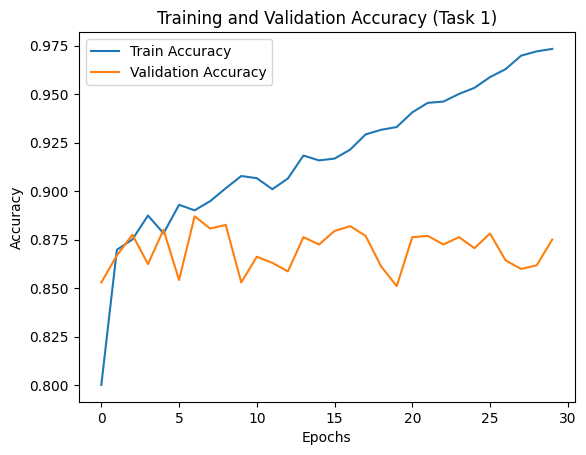

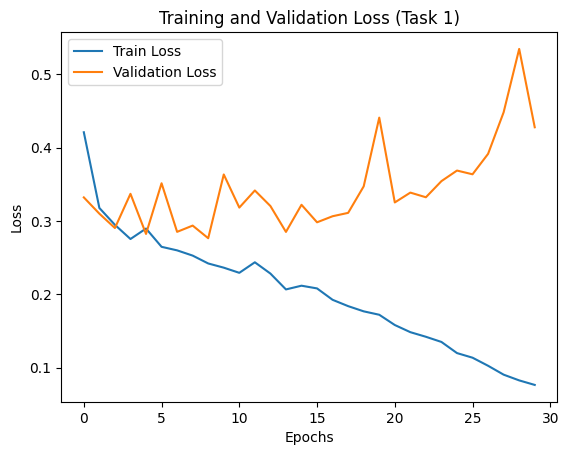

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history_task1.history['accuracy'], label='Train Accuracy')
plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history_task1.history['loss'], label='Train Loss')
plt.plot(history_task1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate
test_loss, test_accuracy = cnn_task1.evaluate(X_test_task1, y_test_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8835 - loss: 0.3677
Test Accuracy (Task 1 - isCancerous): 0.8833


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
y_pred_task1 = (cnn_task1.predict(X_test_task1) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test_task1, y_pred_task1)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_test_task1, y_pred_task1))


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
 [[1062  124]
 [ 107  687]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1186
           1       0.85      0.87      0.86       794

    accuracy                           0.88      1980
   macro avg       0.88      0.88      0.88      1980
weighted avg       0.88      0.88      0.88      1980

